# Part 1: Dataset Preparation and Fine-Tuning (7 points)

In [2]:
import datasets
import pandas as pd
import kagglehub

import os

## Step 1: Download the IMDB Datase

In [18]:
# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

df_kaggle_imdb = pd.read_csv(str(path) + "/IMDB Dataset.csv")
df_kaggle_imdb.head()

Path to dataset files: C:\Users\panup\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Step 2: Data Preprocessing 

In [22]:
df_kaggle_imdb["label"] = [0 if x == "positive" else 1 for x in df_kaggle_imdb["sentiment"]]
df_kaggle_imdb = df_kaggle_imdb[["label", "review"]]
df_kaggle_imdb.head()

,label,review
0,0,One of the other reviewers has mentioned that ...
1,0,A wonderful little production. <br /><br />The...
2,0,I thought this was a wonderful way to spend ti...
3,1,Basically there's a family where a little boy ...
4,0,"Petter Mattei's ""Love in the Time of Money"" is..."


In [34]:
df_shuffled = df_kaggle_imdb.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(0.6 * len(df_shuffled))
valid_size = int(0.2 * len(df_shuffled))

train_df = df_shuffled[:train_size]
valid_df = df_shuffled[train_size: train_size + valid_size]
tests_df = df_shuffled[train_size + valid_size:]

## Step 3: Model Selection and Tokenization

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset

In [4]:
model_name = "distilbert-base-uncased" #"deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model     = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
def tokenize_dataset(examples):
    return tokenizer(examples["review"], truncation=True, padding="max_length", max_length=256)

tokenized_train = Dataset.from_dict(train_df).map(tokenize_dataset, batched=True)
tokenized_eval  = Dataset.from_dict(valid_df).map(tokenize_dataset, batched=True)
tokenized_test  = Dataset.from_dict(tests_df).map(tokenize_dataset, batched=True)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Step 4: Fine-Tune the Model

In [41]:
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

In [43]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",            # Directory to save results and model checkpoints
    eval_strategy="epoch",       # Evaluate the model at the end of each epoch
    learning_rate=1e-3,                # Optimizer learning rate
    per_device_train_batch_size=16,    # Batch size for each GPU or CPU
    num_train_epochs=3,                # Number of training epochs (changed to 3)
    logging_dir='./logs',              # Directory for logging
    logging_steps=10,                  # Log every 10 steps

    report_to="none",
    fp16=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    # For metrics
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Step 5: Save and Upload the Model to Hugging Face

In [1]:
from huggingface_hub import notebook_login
from huggingface_hub import Repository

notebook_login()

In [5]:
save_directory = "./comp-cs530-ta3-model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

[2025-01-31 14:19:35,428] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


W0131 14:19:37.221000 20900 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


('./comp-cs530-ta3-model\\tokenizer_config.json',
 './comp-cs530-ta3-model\\special_tokens_map.json',
 './comp-cs530-ta3-model\\vocab.txt',
 './comp-cs530-ta3-model\\added_tokens.json',
 './comp-cs530-ta3-model\\tokenizer.json')

In [11]:
repo_name = "tinyBert_cs530-ta3"
repo = Repository(
    local_dir=save_directory, 
    clone_from=f"https://huggingface.co/Credioni/tinyBert_cs530-ta3"
)

# Push the model and tokenizer to Hugging Face
repo.push_to_hub()

C:\Users\panup\Documents\Tampereen Yliopisto\COMP.CS.530 Fine-tuning Large Language Models\exercise_3\./comp-cs530-ta3-model is already a clone of https://huggingface.co/Credioni/tinyBert_cs530-ta3. Make sure you pull the latest changes with `repo.git_pull()`.


https://huggingface.co/Credioni/tinyBert_cs530-ta3

# Part 2: API Development and Testing
# Part 3: UI Design and Explanation 

## Step 6, 7, 9, 10, 11, 12 in GitHub

https://github.com/Credioni/COMP.CS.530_LLM_A3.git

# Task 13 - Record a YouTube Demo Video

https://youtu.be/OFnRxsonhAw

Note that CROQ does not support confidence level according to their docs.

## Step 8: Test the API Locally

In [41]:
from IPython.display import Image

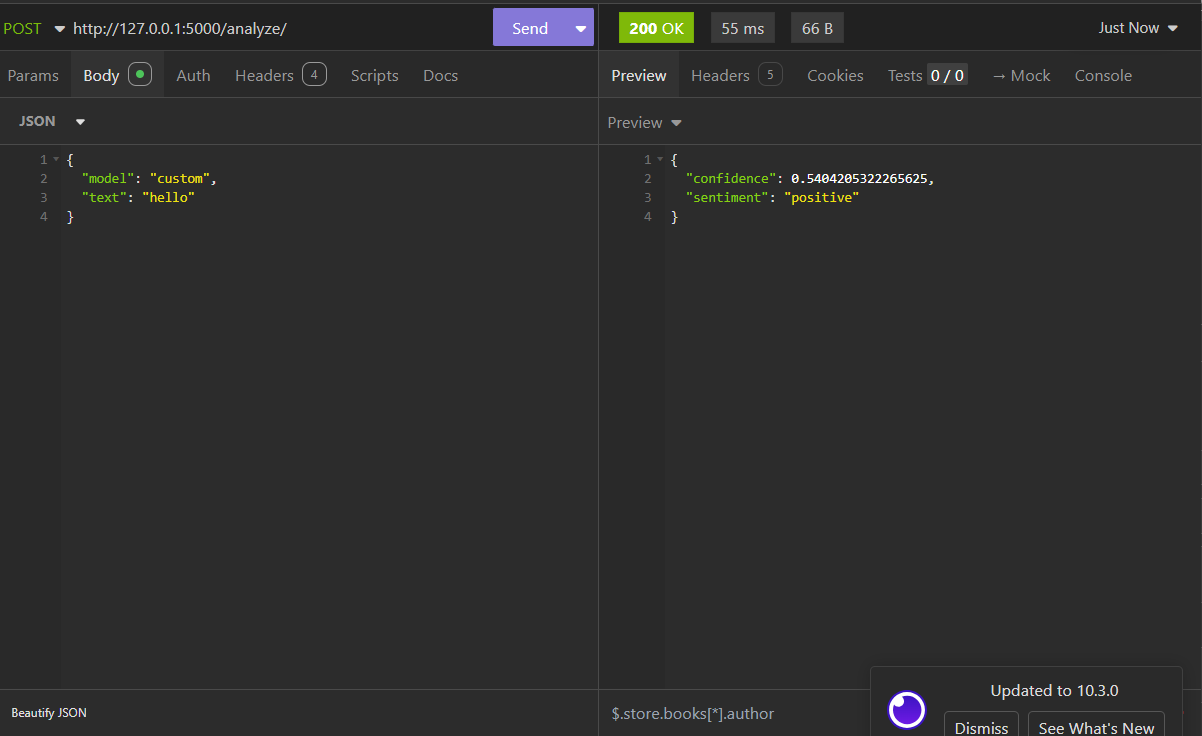

In [42]:
Image("insomnia.png")

In [9]:
import requests

In [27]:
address = "http://127.0.0.1:5000/analyze/"

In [30]:
r = requests.post(address, json={'text': 'Awesome!', "model": "llama"})
print(r.content)

b'{\n  "confidence": 1.0,\n  "sentiment": "positive"\n}\n'


In [36]:
r = requests.post(address, json={'text': 'Awesome!', "model": "custom"})
print(r.content)

b'{\n  "confidence": 0.5589515566825867,\n  "sentiment": "positive"\n}\n'
